In [1]:
#Imports
import pandas as pd
import os
import tensorflow as tf

from scipy.stats import ks_2samp
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

import sys  
sys.path.append("../../")  
from utils.models import *
from utils.datahandling import *
from utils.modelrunner import *

In [2]:
# Define constants and configurations
num_features = 7  # Number of features
sequence_length = 25
batch_size = 16
evaluation_interval = 168
mae_threshold = 0.1
ks_significance_level = 0.05

In [3]:
# Load data
num_users = 30

cwd = os.path.normpath(os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd()))))
df = pd.read_csv(cwd+'/data/3final_data/Final_Totalload_dataset.csv', index_col='Date')
df.index = pd.to_datetime(df.index)
df.fillna(0, inplace=True)

# Filter data for a specific period
start_date = df.index.min() + pd.DateOffset(years=1)
end_date = df.index.max()
df = df[(df.index >= start_date) & (df.index < end_date)]

df = min_max_scaling(df)
df.reset_index(inplace=True, drop=True)

df_array = []
for idx in range(num_users):
    df_array.append(df[[f'User{idx+1}', 'temp', 'rhum', 'wspd', 'PC1', 'hour sin', 'hour cos', f'User{idx+1}_lag_24hrs']])

In [4]:
loss = tf.keras.losses.MeanSquaredError()
metrics=[
    tf.keras.metrics.RootMeanSquaredError(), 
    tf.keras.metrics.MeanAbsolutePercentageError(),
    tf.keras.metrics.MeanAbsoluteError(),
]

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10,mode='min')
timing_callback = TimingCallback()
custom_callback = CustomCallback()

callbacks=[early_stopping, timing_callback, custom_callback]

custom_objects = {'EinsumLayer': EinsumLayer,'TopKLayer': TopKLayer,'ImportanceRegularizationLayer': ImportanceRegularizationLayer}

In [5]:
def load_and_compile_model(model_path, model_type, custom_objects=None):
    model = tf.keras.models.load_model(model_path, custom_objects=custom_objects, compile=False)
    model.compile(loss=loss, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=metrics)
    return model

def calculate_metrics(actual, predictions):
    return {
        'RMSE': np.sqrt(mean_squared_error(actual, predictions)),
        'MAE': mean_absolute_error(actual, predictions),
        'MSE': mean_squared_error(actual, predictions)
    }

def check_concept_drift(actual_interval, predicted_interval, previous_mae, mae_threshold, ks_significance_level, cd_mae_counter, cd_ks_counter):
   
    current_mae = mean_absolute_error(actual_interval, predicted_interval)
    
    if not np.isnan(previous_mae) and current_mae > previous_mae * (1 + mae_threshold):
        cd_mae_counter += 1

    ks_pvalue = ks_2samp(actual_interval, predicted_interval).pvalue
    if ks_pvalue < ks_significance_level:
        cd_ks_counter += 1 

    return cd_mae_counter, cd_ks_counter, current_mae

In [6]:
# Initialize DataFrame to store results
forecast_type = "Totalload"
columns = ['User', 'Round', 'CD_mae_count', 'CD_ks_count']
model_names = ['BiLSTM', 'CNN', 'Transformer', 'soft_dense', 'soft_bilstm', 'topk_dense', 'topk_bilstm']

for name in model_names:
    columns.extend([f'RMSE_{name}', f'MAE_{name}', f'MSE_{name}'])

results_df = pd.DataFrame(columns=columns)

num_rounds = 5
for round in range(num_rounds):
    for user_index, user_df in enumerate(df_array):
        
        print("Round ", round +1, "/ ", num_rounds, ", User ", user_index+1, " / ", num_users)

        model_paths = {
            'BiLSTM': f'{cwd}/src/time_series/Locallearning/TS_LL_{forecast_type}_Forecasting_Benchmark/wandb/TS_LL_{forecast_type}_bilstm_u{user_index+1}_rd{round+1}.keras',
            'CNN': f'{cwd}/src/time_series/Locallearning/TS_LL_{forecast_type}_Forecasting_Benchmark/wandb/TS_LL_{forecast_type}_cnn_u{user_index+1}_rd{round+1}.keras',
            'Transformer': f'{cwd}/src/time_series/Locallearning/TS_LL_{forecast_type}_Forecasting_Benchmark/wandb/TS_LL_{forecast_type}_transformer_u{user_index+1}_rd{round+1}.keras',
            'soft_bilstm': f'{cwd}/src/time_series/Locallearning/TS_LL_{forecast_type}_Forecasting_Moe/wandb/TS_LL_{forecast_type}_lstm_soft_moe_u{user_index+1}_rd{round+1}.keras',
            'soft_dense': f'{cwd}/src/time_series/Locallearning/TS_LL_{forecast_type}_Forecasting_Moe/wandb/TS_LL_{forecast_type}_dense_soft_moe_u{user_index+1}_rd{round+1}.keras',
            'topk_bilstm': f'{cwd}/src/time_series/Locallearning/TS_LL_{forecast_type}_Forecasting_Moe/wandb/TS_LL_{forecast_type}_lstm_topk_moe_u{user_index+1}_rd{round+1}.keras',
            'topk_dense': f'{cwd}/src/time_series/Locallearning/TS_LL_{forecast_type}_Forecasting_Moe/wandb/TS_LL_{forecast_type}_dense_topk_moe_u{user_index+1}_rd{round+1}.keras'
        }
        models = {name: load_and_compile_model(path, name, custom_objects) for name, path in model_paths.items()}
               
        # Stream data simulation, initialization
        stream_data = user_df.values
        stream_buffer = []
        actual_values = []
        cd_mae_counter, cd_ks_counter = 0,0
        previous_mae_bilstm = np.NaN
        stream_predictions = {name: [] for name in model_names}
    
        # Enumerate through the data stream
        for idx, data in enumerate(stream_data):
            
            # Buffer: Append data (1 row is one array) to the buffer and pop oldest if sequence_length is surpassed.
            stream_buffer.append(data)
            
            # Check if we have enough data for a batch prediction
            if len(stream_buffer) >= batch_size + sequence_length - 1:
                # Prepare batch data for prediction
                batch_data = []
                for i in range(batch_size):
                    x_pred = np.array([stream_buffer[i:i+sequence_length-1]])
                    batch_data.append(x_pred)              
                
                # Convert list to numpy array for prediction
                batch_data = np.concatenate(batch_data, axis=0)  # Shape becomes (16, 24, 8)

                # Make predictions for each model
                for name, model in models.items():
                    predictions = model.predict(batch_data, callbacks=callbacks, verbose=0)
                    stream_predictions[name].extend(predictions[:, 0].tolist())

                # Append actual values for the batch
                actual_values.extend([d[0] for d in stream_buffer[-batch_size:]])
                # Clear the processed batch data from buffer
                del stream_buffer[:batch_size]

            # Check and evaluate at every evaluation_interval
            if (idx + 1) % evaluation_interval == 0 and len(actual_values) >= evaluation_interval:
                actual_interval = actual_values[-evaluation_interval:]
                predicted_interval = stream_predictions['BiLSTM'][-evaluation_interval:]  # Example for BiLSTM

                cd_mae_counter, cd_ks_counter, current_mae = check_concept_drift(
                    actual_interval, predicted_interval, previous_mae_bilstm, mae_threshold, ks_significance_level, cd_mae_counter, cd_ks_counter
                )
                                
                previous_mae_bilstm = current_mae   
                   
        # Calculate metrics for each model and append to DataFrame
        if actual_values:
            metrics_data = {'User': user_index+1, 'Round': round+1, 'CD_mae_count': cd_mae_counter, 'CD_ks_count': cd_ks_counter}
            for name in model_names:
                metrics_data.update({f'{metric}_{name}': value for metric, value in calculate_metrics(actual_values, stream_predictions[name]).items()})
            results_df.loc[len(results_df)] = metrics_data
           
results_df

Round  1 /  5 , User  1  /  30
Round  1 /  5 , User  2  /  30
Round  1 /  5 , User  3  /  30
Round  1 /  5 , User  4  /  30
Round  1 /  5 , User  5  /  30
Round  1 /  5 , User  6  /  30
Round  1 /  5 , User  7  /  30
Round  1 /  5 , User  8  /  30
Round  1 /  5 , User  9  /  30
Round  1 /  5 , User  10  /  30
Round  1 /  5 , User  11  /  30
Round  1 /  5 , User  12  /  30
Round  1 /  5 , User  13  /  30
Round  1 /  5 , User  14  /  30
Round  1 /  5 , User  15  /  30
Round  1 /  5 , User  16  /  30
Round  1 /  5 , User  17  /  30
Round  1 /  5 , User  18  /  30
Round  1 /  5 , User  19  /  30
Round  1 /  5 , User  20  /  30
Round  1 /  5 , User  21  /  30
Round  1 /  5 , User  22  /  30
Round  1 /  5 , User  23  /  30
Round  1 /  5 , User  24  /  30
Round  1 /  5 , User  25  /  30
Round  1 /  5 , User  26  /  30
Round  1 /  5 , User  27  /  30
Round  1 /  5 , User  28  /  30
Round  1 /  5 , User  29  /  30
Round  1 /  5 , User  30  /  30
Round  2 /  5 , User  1  /  30
Round  2 /  5 , Us

,User,Round,CD_mae_count,CD_ks_count,RMSE_BiLSTM,MAE_BiLSTM,MSE_BiLSTM,RMSE_CNN,MAE_CNN,MSE_CNN,...,MSE_soft_dense,RMSE_soft_bilstm,MAE_soft_bilstm,MSE_soft_bilstm,RMSE_topk_dense,MAE_topk_dense,MSE_topk_dense,RMSE_topk_bilstm,MAE_topk_bilstm,MSE_topk_bilstm
0,1,1,21,103,0.132588,0.088298,0.017580,0.185590,0.147238,0.034443,...,0.015397,0.122621,0.083679,0.015036,0.123905,0.086798,0.015352,0.123300,0.086374,0.015203
1,2,1,26,103,0.115778,0.083177,0.013405,0.121569,0.089501,0.014779,...,0.014211,0.110334,0.075355,0.012174,0.113113,0.076097,0.012795,0.117370,0.089445,0.013776
2,3,1,23,103,0.085905,0.061510,0.007380,0.094593,0.072909,0.008948,...,0.008209,0.074733,0.043897,0.005585,0.095658,0.066197,0.009151,0.090926,0.067191,0.008268
3,4,1,36,103,0.091701,0.048958,0.008409,0.123576,0.070452,0.015271,...,0.006858,0.083544,0.047657,0.006980,0.085236,0.045312,0.007265,0.085233,0.045105,0.007265
4,5,1,22,103,0.115502,0.087866,0.013341,0.140812,0.112408,0.019828,...,0.011715,0.116655,0.093950,0.013608,0.108229,0.077325,0.011713,0.110500,0.080515,0.012210
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,26,5,35,93,0.092188,0.051747,0.008499,0.122502,0.086028,0.015007,...,0.007630,0.086827,0.050561,0.007539,0.086835,0.056061,0.007540,0.089635,0.054157,0.008034
146,27,5,20,103,0.083511,0.058852,0.006974,0.110131,0.088075,0.012129,...,0.006066,0.077476,0.050977,0.006003,0.080966,0.058630,0.006555,0.085725,0.064287,0.007349
147,28,5,34,97,0.069947,0.035718,0.004893,0.080275,0.048633,0.006444,...,0.004618,0.068644,0.030213,0.004712,0.069409,0.030966,0.004818,0.067870,0.032627,0.004606
148,29,5,27,103,0.108054,0.075665,0.011676,0.133134,0.096794,0.017725,...,0.009632,0.097291,0.065333,0.009466,0.103852,0.072994,0.010785,0.100600,0.064010,0.010120


In [7]:
predictions_df = pd.DataFrame.from_dict(stream_predictions)

predictions_df.to_csv(f'results/Predictions_DS_LL_{forecast_type}_Forecasting.csv')  
results_df.to_csv(f'results/Results_DS_LL_{forecast_type}_Forecasting.csv')  

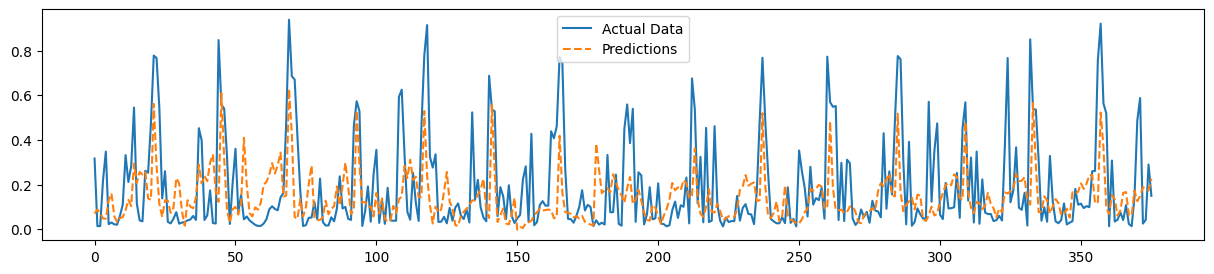

In [8]:
# Plotting to visualize the results
plt.figure(figsize=(15, 3))
plt.plot(df['User1'][124:500].values, label='Actual Data')
plt.plot(stream_predictions["soft_bilstm"][124:500], label='Predictions', linestyle='dashed')
plt.legend()
plt.show()